In [69]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [70]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

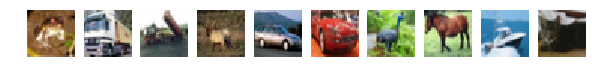

In [71]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [72]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [73]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [74]:
# Create an instance of the model and show model summary

model = get_new_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
__________________________________________________

In [75]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

accuracy: 0.077


#### Train model with checkpoints

In [76]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [77]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             frequency='epoch',
                             save_weights_only=True,
                             verbose=1)

In [78]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch

model.fit(x=x_train,
          y=y_train,
          epochs=3,
          callbacks=[checkpoint])

Train on 10000 samples
Epoch 1/3
 9984/10000 [============================>.] - ETA: 0s - loss: 2.0119 - accuracy: 0.2568 E
Epoch 00001: saving model to model_checkpoints/checkpoint
10000/10000 [==============================] - 51s 5ms/sample - loss: 2.0115 - accuracy: 0.2567
Epoch 2/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.6167 - accuracy: 0.4087
Epoch 00002: saving model to model_checkpoints/checkpoint
10000/10000 [==============================] - 50s 5ms/sample - loss: 1.6163 - accuracy: 0.4089
Epoch 3/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.4818 - accuracy: 0.4604
Epoch 00003: saving model to model_checkpoints/checkpoint
10000/10000 [==============================] - 50s 5ms/sample - loss: 1.4821 - accuracy: 0.4601


In [79]:
# Have a look at what the checkpoint creates

! ls -lh model_checkpoints

total 184K
-rw-r--r-- 1 jovyan users   77 Nov 26 05:01 checkpoint
-rw-r--r-- 1 jovyan users 174K Nov 26 05:01 checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Nov 26 05:01 checkpoint.index


In [80]:
# Evaluate the performance of the trained model

get_test_accuracy(model, x_test, y_test)

accuracy: 0.468


#### Create new model, load weights

In [81]:
# Create a new instance of the (initialised) model, accuracy around 10% again

model = get_new_model()
get_test_accuracy(model, x_test, y_test)

accuracy: 0.120


In [82]:
# Load weights -- accuracy is the same as the trained model

model.load_weights(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.468


#### Clear directory

In [83]:
! rm -r model_checkpoints

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

In [84]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [85]:
# Create Tensorflow checkpoint object with epoch and batch details

checkpoint_5000_path = 'model_checkpoints_5000/checkpoint_{epoch:02d}_{batch:04d}'
checkpoint_5000 = ModelCheckpoint(filepath=checkpoint_5000_path,
                                  save_weights_only=True,
                                  save_freq=5000,
                                  verbose=1)

In [86]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x=x_train,
          y=y_train,
          epochs=3,
          validation_data=(x_test, y_test),
          batch_size=10,
          callbacks=[checkpoint_5000])

Train on 10000 samples, validate on 1000 samples
Epoch 1/3
 4990/10000 [=============>................] - ETA: 32s - loss: 2.0584 - accuracy: 0.2427
Epoch 00001: saving model to model_checkpoints_5000/checkpoint_01_0499
 9990/10000 [============================>.] - ETA: 0s - loss: 1.8998 - accuracy: 0.3049
Epoch 00001: saving model to model_checkpoints_5000/checkpoint_01_0999
10000/10000 [==============================] - 66s 7ms/sample - loss: 1.8997 - accuracy: 0.3048 - val_loss: 1.6538 - val_accuracy: 0.4100
Epoch 2/3
 4980/10000 [=============>................] - ETA: 31s - loss: 1.5881 - accuracy: 0.4189
Epoch 00002: saving model to model_checkpoints_5000/checkpoint_02_0499
 9980/10000 [============================>.] - ETA: 0s - loss: 1.5581 - accuracy: 0.4321
Epoch 00002: saving model to model_checkpoints_5000/checkpoint_02_0999
10000/10000 [==============================] - 64s 6ms/sample - loss: 1.5580 - accuracy: 0.4320 - val_loss: 1.4778 - val_accuracy: 0.4680
Epoch 3/3
 49

In [87]:
# Have a look at what the checkpoint creates

! ls -lh model_checkpoints_5000

total 1.1M
-rw-r--r-- 1 jovyan users   93 Nov 26 05:05 checkpoint
-rw-r--r-- 1 jovyan users 174K Nov 26 05:02 checkpoint_01_0499.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Nov 26 05:02 checkpoint_01_0499.index
-rw-r--r-- 1 jovyan users 174K Nov 26 05:03 checkpoint_01_0999.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Nov 26 05:03 checkpoint_01_0999.index
-rw-r--r-- 1 jovyan users 174K Nov 26 05:03 checkpoint_02_0499.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Nov 26 05:03 checkpoint_02_0499.index
-rw-r--r-- 1 jovyan users 174K Nov 26 05:04 checkpoint_02_0999.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Nov 26 05:04 checkpoint_02_0999.index
-rw-r--r-- 1 jovyan users 174K Nov 26 05:04 checkpoint_03_0499.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Nov 26 05:04 checkpoint_03_0499.index
-rw-r--r-- 1 jovyan users 174K Nov 26 05:05 checkpoint_03_0999.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Nov 26 05:05 checkpoint_03_0999.index


#### Work with model saving criteria

In [88]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [89]:
# Create a new instance of untrained model

model = get_new_model()

In [90]:
# Create Tensorflow checkpoint object which monitors the validation accuracy

checkpoint_best_path = 'model_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                  save_weights_only=True,
                                  save_freq='epoch',
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  verbose=1)

In [91]:
# Fit the model and save only the weights with the highest validation accuracy

history = model.fit(x=x_train,
                    y=y_train,
                    epochs=50,
                    validation_data=(x_test, y_test),
                    batch_size=10,
                    callbacks=[checkpoint_best],
                    verbose=0)


Epoch 00001: val_accuracy improved from -inf to 0.05000, saving model to model_checkpoints_best/checkpoint

Epoch 00002: val_accuracy improved from 0.05000 to 0.06000, saving model to model_checkpoints_best/checkpoint

Epoch 00003: val_accuracy improved from 0.06000 to 0.07000, saving model to model_checkpoints_best/checkpoint

Epoch 00004: val_accuracy did not improve from 0.07000

Epoch 00005: val_accuracy did not improve from 0.07000

Epoch 00006: val_accuracy did not improve from 0.07000

Epoch 00007: val_accuracy improved from 0.07000 to 0.10000, saving model to model_checkpoints_best/checkpoint

Epoch 00008: val_accuracy did not improve from 0.10000

Epoch 00009: val_accuracy did not improve from 0.10000

Epoch 00010: val_accuracy did not improve from 0.10000

Epoch 00011: val_accuracy did not improve from 0.10000

Epoch 00012: val_accuracy did not improve from 0.10000

Epoch 00013: val_accuracy did not improve from 0.10000

Epoch 00014: val_accuracy did not improve from 0.10000

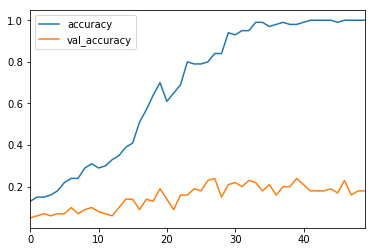

In [92]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [93]:
# Inspect the checkpoint directory

! ls -lh model_checkpoints_best

total 184K
-rw-r--r-- 1 jovyan users   77 Nov 26 05:05 checkpoint
-rw-r--r-- 1 jovyan users 174K Nov 26 05:05 checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Nov 26 05:05 checkpoint.index


In [94]:
# Create a new model with the saved weights

new_model = get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.240


#### Clear directory

In [95]:
! rm -r model_checkpoints_5000 model_checkpoints_best

***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [96]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [97]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=False,
                             frequency='epoch',
                             verbose=1)

In [98]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x=x_train,
          y=y_train,
          epochs=3,
          callbacks=[checkpoint])

Train on 100 samples
Epoch 1/3
 96/100 [===========================>..] - ETA: 0s - loss: 2.3078 - accuracy: 0.1250
Epoch 00001: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
100/100 [==============================] - 3s 34ms/sample - loss: 2.3074 - accuracy: 0.1200
Epoch 2/3
 96/100 [===========================>..] - ETA: 0s - loss: 2.2693 - accuracy: 0.1979
Epoch 00002: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
100/100 [==============================] - 2s 19ms/sample - loss: 2.2672 - accuracy: 0.1900
Epoch 3/3
 96/100 [===========================>..] - ETA: 0s - loss: 2.2581 - accuracy: 0.1875
Epoch 00003: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
100/100 [==============================] - 2s 18ms/sample - loss: 2.2491 - accuracy: 0.1900


#### Inspect what the checkpoint has created

In [99]:
# Have a look at what the checkpoint creates

! ls -lh model_checkpoints

total 128K
drwxr-xr-x 2 jovyan users 6.0K Nov 26 05:06 assets
-rw-r--r-- 1 jovyan users 119K Nov 26 05:06 saved_model.pb
drwxr-xr-x 2 jovyan users 6.0K Nov 26 05:06 variables


In [100]:
# Enter variables directory

! ls -lh model_checkpoints/variables

total 184K
-rw-r--r-- 1 jovyan users 177K Nov 26 05:06 variables.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.1K Nov 26 05:06 variables.index


In [101]:
# Get the model's test accuracy

get_test_accuracy(model, x_test, y_test)

accuracy: 0.110


#### Create new model from scratch

In [102]:
# Delete model

del model

In [103]:
from tensorflow.keras.models import load_model

In [104]:
# Reload model from scratch

model = load_model(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.110


#### Use the .h5 format to save model

In [105]:
# Save the model in .h5 format

model.save('my_model.h5')

In [106]:
# Inspect .h5 file

! ls -lh my_model.h5

-rw-r--r-- 1 jovyan users 77K Nov 26 05:06 my_model.h5


In [107]:
# Delete model

del model

In [108]:
# Reload model from scratch

model = load_model('my_model.h5')
get_test_accuracy(model, x_test, y_test)

accuracy: 0.110


#### Clear directory

In [109]:
! rm -r model_checkpoints
! rm my_model.h5

***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Keras HDF5 format. If you want to import it on your personal machine, use the following code:

```python
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')
```

In this coding tutorial, you will instead load the model directly from disk.

In [110]:
from tensorflow.keras.models import load_model

In [ ]:
# Build Keras ResNet50 model



#### Import and preprocess 3 sample images

In [ ]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('data/lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('data/viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('data/water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [ ]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

In [ ]:
# Display image



In [ ]:
# Display top 5 predictions



##### Image 2: viaduct

In [ ]:
# Display image



In [ ]:
# Display top 5 predictions



##### Image 3: water tower

In [ ]:
# Display image



In [ ]:
# Display top 5 predictions



***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Tensorflow SavedModel format. If you want to import it on your personal machine, use the following code:

```python
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
```

In this coding tutorial, you will instead load the model directly from disk.

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

In [ ]:
# Build Google's Mobilenet v1 model



#### Use MobileNet model to classify images

In [ ]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("data/lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("data/viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("data/water_tower.jpg", target_size=(160, 160))

In [ ]:
# Read in categories text file

with open('data/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [ ]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: lemon

##### Image 2: viaduct

##### Image 3: water tower